In [75]:
import os
import sys
import h5py
import numpy as np
import torch
# import BART
os.environ['TOOLBOX_PATH'] = "/home/svangurp/scratch/samuel/bart-0.6.00/"
sys.path.append('/home/svangurp/scratch/samuel/bart-0.6.00/python/')
import bart
import fastmri.data.transforms as T
from fastmri.data.subsample import create_mask_for_mask_type
from fastmri import tensor_to_complex_np
import matplotlib.pyplot as plt

In [ ]:
# read the files on my local computer

# os.chdir('/Users/korat/Desktop/BEP/Programmeren/fastmri/brain/train')

# fname = 'file_brain_AXFLAIR_200_6002425.h5'
# data = h5py.File(fname, 'r')
# data.keys()

In [ ]:
# Cell reads data on the hinton server 
# reading knee data
# fname = '/home/svangurp/scratch/samuel/data/knee/train/file1000001.h5'
# data = h5py.File(fname, 'r')
# data.keys()


In [ ]:
# kspace_complex = data['kspace'][()] # in this one i don't split the coplex values
# kspace = data['kspace'][()]
# recon_rss= data['reconstruction_rss'][()]
# print('shape k-space:',kspace.shape, '. shape reconstructed data',recon_rss.shape)

In [16]:

# open file
fname = '/scratch/svangurp/samuel/data/knee/train/file1000002.h5'
# read h5 file
data = h5py.File(fname, 'r')
# extract the multi coil k-space data
kspace = data["kspace"][()]
# selecting a single slice to work on
slice = 20

target = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(kspace[slice], axes=(-2, -1)), axes=(-2, -1)), axes=(-2, -1))

# RSS combination
target = np.sqrt(np.sum(T.center_crop(target, (320, 320)) ** 2, 0))

crop_size = (320, 320)

# applying a random mask
mask_func = create_mask_for_mask_type(mask_type_str="random", center_fractions=[0.08], accelerations=[4])

# transforming one slice of the multi coil k-space data
_kspace = T.to_tensor(kspace)[slice]
# applying the mask to the one slice of the multi coil k-space data
masked_kspace, mask = T.apply_mask(_kspace, mask_func)

# splitting the values 
linear_recon = masked_kspace[..., 0] + 1j * masked_kspace[..., 1]
# going to image space
linear_recon = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(linear_recon, axes=(-2, -1)), axes=(-2, -1)),

                               axes=(-2, -1))
# RSS coil combination 
linear_recon = np.sqrt(np.sum(T.center_crop(linear_recon, (320, 320)) ** 2, 0))

# like fftshift 
masked_kspace = masked_kspace.permute(1, 2, 0, 3).unsqueeze(0)


masked_kspace = tensor_to_complex_np(masked_kspace)
# estemating the sens maps
sens_maps = bart.bart(1, "ecalib -d0 -m1", masked_kspace)

# parameters for the reconstruction
reg_wt = 0.01
num_iters = 200

pred = bart.bart(1, f"pics -d0 -S -R T:7:0:{reg_wt} -i {num_iters}", masked_kspace, sens_maps)

pred = torch.from_numpy(np.abs(pred[0]))

# check for FLAIR 203

if pred.shape[1] < crop_size[1]:

    crop_size = (pred.shape[1], pred.shape[1])

pred = T.center_crop(pred, crop_size)

print('Done')

Done


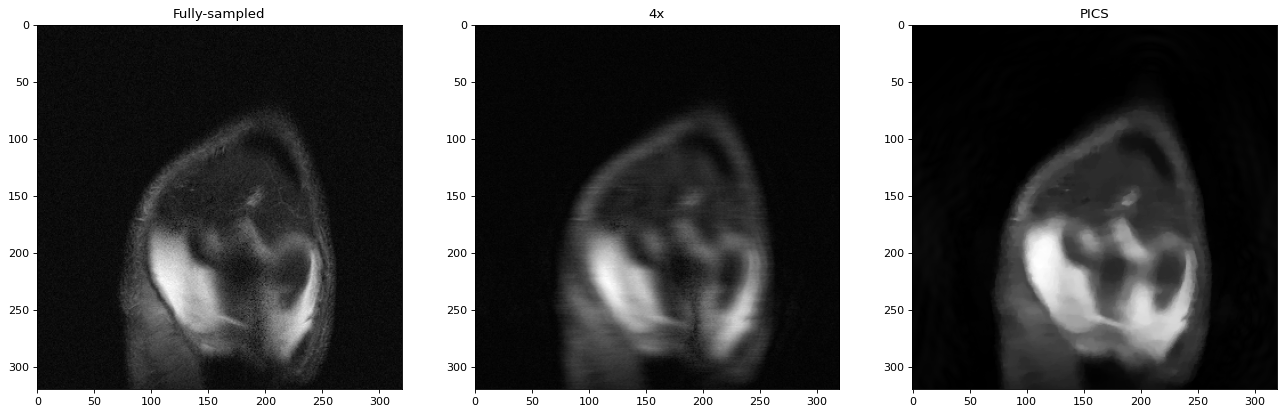

In [15]:

# plotting
plt.figure(figsize=(20,18), dpi = 80)
plt.subplot(1, 3, 1)

plt.imshow(np.abs(target), cmap='gray')

plt.title('Fully-sampled')

plt.subplot(1, 3, 2)

plt.imshow(np.abs(linear_recon), cmap='gray')

plt.title('4x')

plt.subplot(1, 3, 3)

plt.imshow(np.abs(pred), cmap='gray')

plt.title('PICS')

plt.show()


In [6]:
diff_4x = np.sqrt(np.subtract(target,linear_recon)**2)
rms_err_4x = abs(sum(sum(diff_4x)))
print(rms_err_4x)

diff_pics = np.sqrt(np.subtract(target,pred)**2)
rms_err_pics = abs(sum(sum(diff_pics)))
print(rms_err_pics)

0.000631922284500087
tensor(2.1499, dtype=torch.float64)


In [7]:
def tensor_to_array(tensor):
    #  takes 2d tensor
    height, width = tensor.shape
    array = np.zeros((height, width))
    
    for i in range(0,height-1):
        for j in range(0,width-1):
            element = tensor[i,j]
            array[i,j] = abs(element)
           
            
    return array


complex128


In [17]:
# calculate the differens from the recon to the fully sampled data, and calculate the rms error

diff_4x = np.sqrt(abs(np.subtract(target,linear_recon))**2)

rms_err_4x = abs(sum(sum(diff_4x)))
print(rms_err_4x)


pred_array = tensor_to_array(pred)

diff_pics = np.sqrt(np.subtract(target,pred_array)**2)
rms_err_pics = abs(sum(sum(diff_pics)))
print(rms_err_pics)


0.0012251175366378157
1.7416392998260266


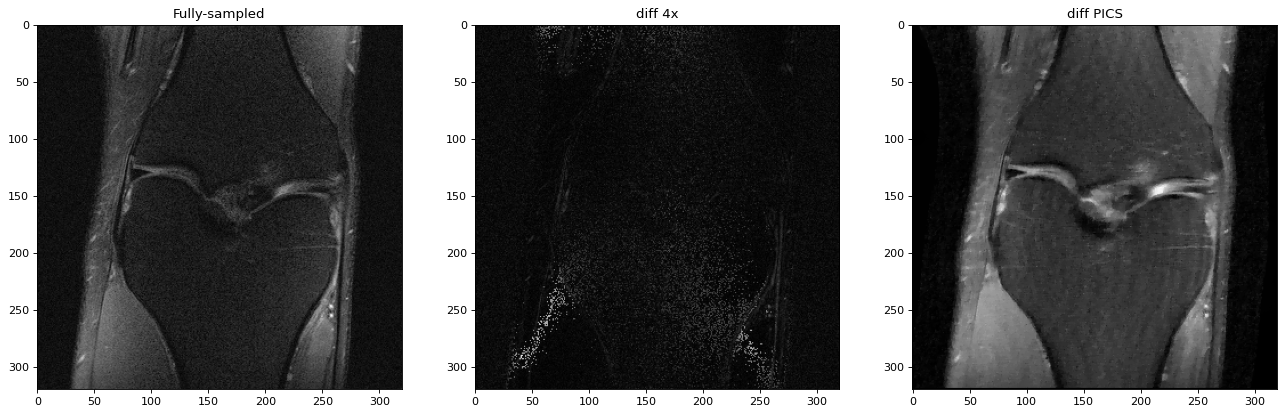

In [18]:
diff_4x = np.subtract(target,linear_recon)
diff_pics = np.subtract(target,pred_array)

# plotting
plt.figure(figsize=(20,18), dpi = 80)
plt.subplot(1, 3, 1)

plt.imshow(np.abs(target), cmap='gray')

plt.title('Fully-sampled')

plt.subplot(1, 3, 2)

plt.imshow(np.abs(diff_4x), cmap='gray')

plt.title('diff 4x')

plt.subplot(1, 3, 3)

plt.imshow(np.abs(diff_pics), cmap='gray')

plt.title('diff PICS')

plt.show()


In [21]:
diff_4x = np.array(abs(np.subtract(target,linear_recon)))
diff_pics = np.array(abs(np.subtract(target,pred_array)))


diff_4x_norm = diff_4x /np.max(diff_4x)
diff_pics_norm = diff_pics / np.max(diff_pics)
target_norm = target / np.max(target)

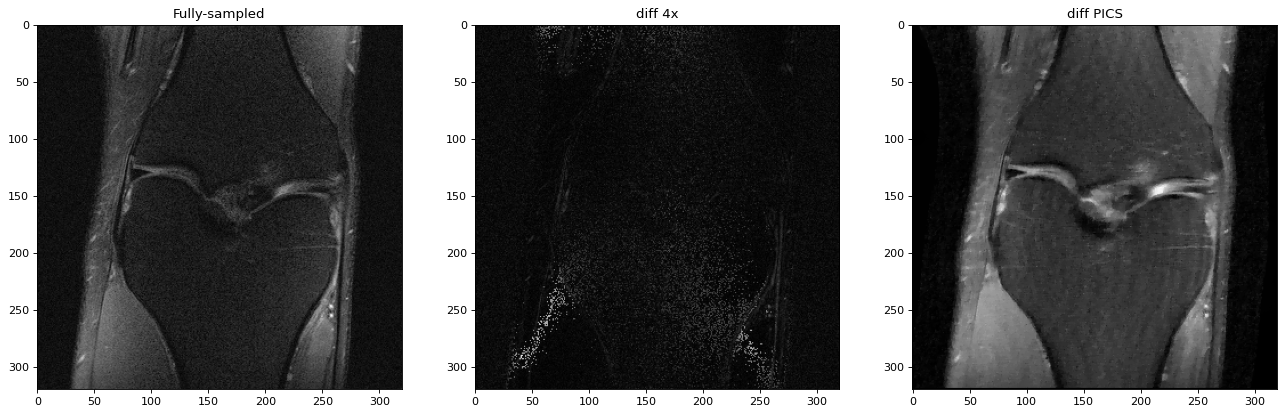

In [22]:
# plotting norm of the difference
plt.figure(figsize=(20,18), dpi = 80)
plt.subplot(1, 3, 1)

plt.imshow(np.abs(target_norm), cmap='gray')

plt.title('Fully-sampled')

plt.subplot(1, 3, 2)

plt.imshow(np.abs(diff_4x_norm), cmap='gray')

plt.title('diff 4x')

plt.subplot(1, 3, 3)

plt.imshow(np.abs(diff_pics_norm), cmap='gray')

plt.title('diff PICS')

plt.show()


In [76]:




fname = '/scratch/svangurp/samuel/data/knee/train/file1000002.h5'
data = h5py.File(fname, 'r')

kspace = data["kspace"][()]


slice = 20

crop_size = (320, 320)

device = 'cuda'



target = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(kspace[slice], axes=(-2, -1)), axes=(-2, -1)), axes=(-2, -1))

target = target / np.max(np.abs(target))

target = np.sqrt(np.sum(T.center_crop(target, crop_size) ** 2, 0))


crop_size = (320, 320)

mask_func = create_mask_for_mask_type(mask_type_str="random", center_fractions=[0.08], accelerations=[4])


_kspace = T.to_tensor(kspace)[slice]

masked_kspace, mask = T.apply_mask(_kspace, mask_func)



linear_recon = masked_kspace[..., 0] + 1j * masked_kspace[..., 1]

linear_recon = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(linear_recon, axes=(-2, -1)), axes=(-2, -1)),

                               axes=(-2, -1))

linear_recon = linear_recon / np.max(np.abs(linear_recon))

linear_recon = np.sqrt(np.sum(T.center_crop(linear_recon, (320, 320)) ** 2, 0))



masked_kspace = masked_kspace.permute(1, 2, 0, 3).unsqueeze(0)

masked_kspace = tensor_to_complex_np(masked_kspace)



sens_maps = bart.bart(1, "ecalib -d0 -m1", masked_kspace)



reg_wt = 0.01

num_iters = 200

pred = np.abs(bart.bart(1, f"pics -d0 -S -R T:7:0:{reg_wt} -i {num_iters}", masked_kspace, sens_maps)[0])

pred = torch.from_numpy(pred / np.max(np.abs(pred))).cpu().numpy()


# check for FLAIR 203

if pred.shape[1] < crop_size[1]:

    crop_size = (pred.shape[1], pred.shape[1])



pred = T.center_crop(pred, crop_size)





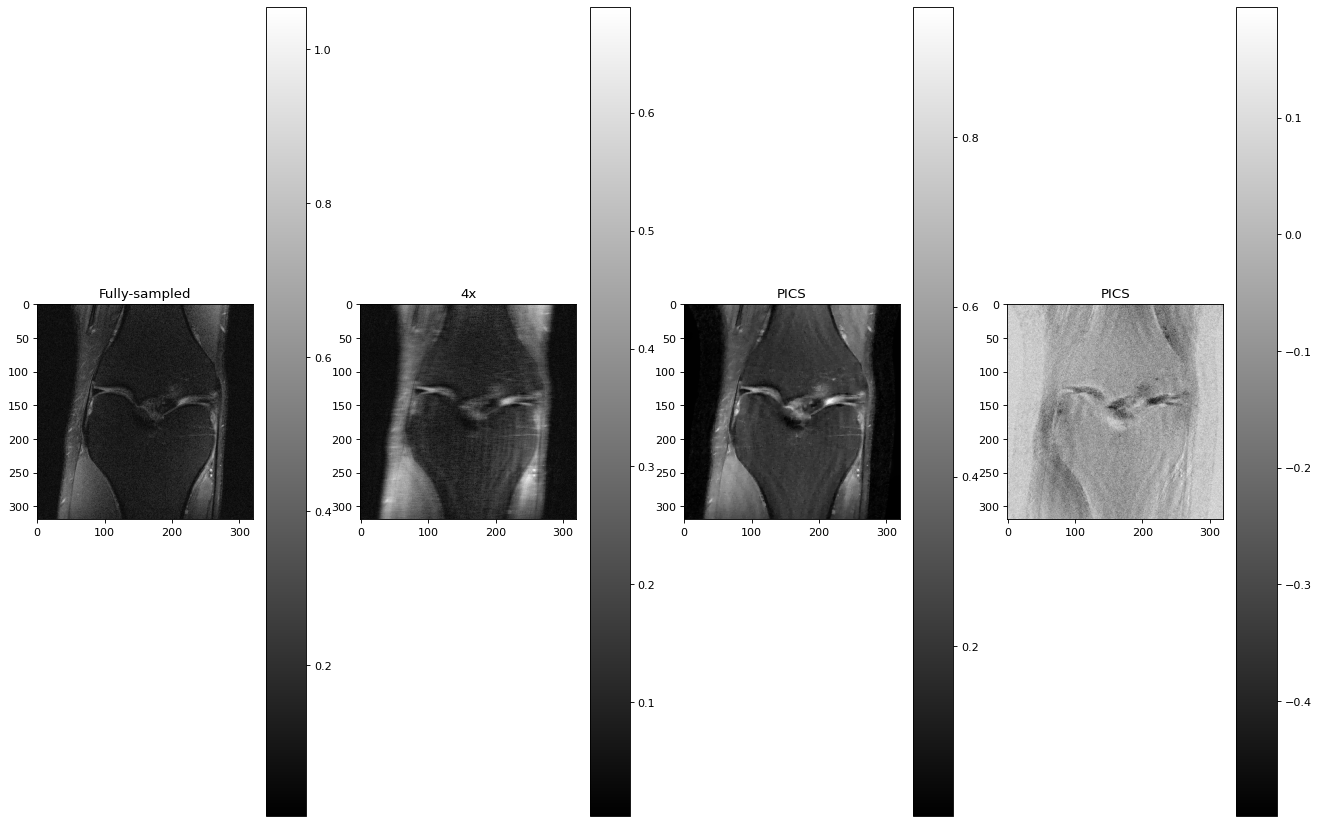

<function print>

In [77]:
plt.figure(figsize=(20,18), dpi = 80)
plt.subplot(1, 4, 1)

plt.imshow(np.abs(target), cmap='gray')

plt.title('Fully-sampled')

plt.colorbar()

plt.subplot(1, 4, 2)

plt.imshow(np.abs(linear_recon), cmap='gray')

plt.title('4x')

plt.colorbar()

plt.subplot(1, 4, 3)

plt.imshow(np.abs(pred), cmap='gray')

plt.title('PICS')

plt.colorbar()

plt.subplot(1, 4, 4)

plt.imshow(np.abs(target)-np.abs(pred), cmap='gray')

plt.title('PICS')

plt.colorbar()

plt.show()
print


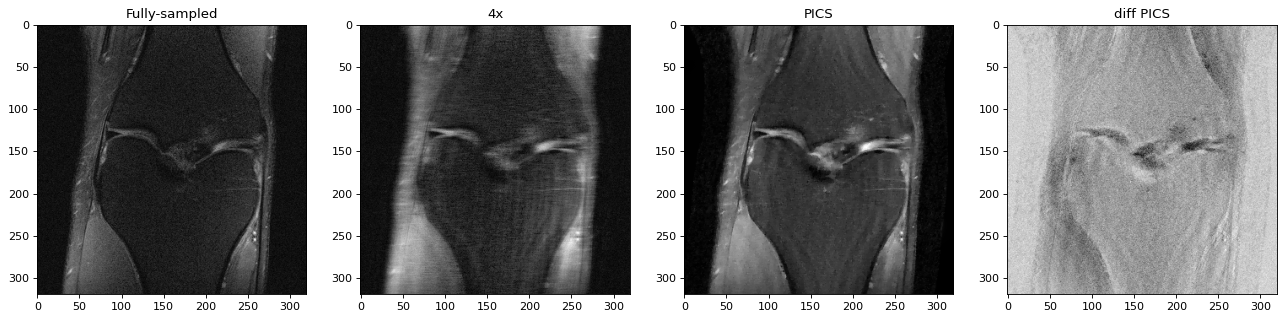

<function print>

In [81]:
plt.figure(figsize=(20,18), dpi = 80)
plt.subplot(1, 4, 1)

plt.imshow(np.abs(target), cmap='gray')

plt.title('Fully-sampled')

plt.subplot(1, 4, 2)

plt.imshow(np.abs(linear_recon), cmap='gray')

plt.title('4x')



plt.subplot(1, 4, 3)

plt.imshow(np.abs(pred), cmap='gray')

plt.title('PICS')


plt.subplot(1, 4, 4)

plt.imshow(np.abs(target)-np.abs(pred), cmap='gray')

plt.title('diff PICS')


plt.show()
print


In [92]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

target = np.abs(target) / np.max(np.abs(target))
pred = np.abs(pred) / np.max(np.abs(pred))
pred = np.abs(linear_recon) / np.max(np.abs(linear_recon))


SSIM_pics = structural_similarity(abs(target), abs(pred))
SSIM_lin_recon = structural_similarity(abs(target), abs(linear_recon))

print('SSIM_pics:',SSIM_pics)
print('SSIM_lin_recon:', SSIM_lin_recon)

SSIM_pics: 0.7174266225708795
SSIM_lin_recon: 0.7720019210220879
